- Similar to end of 2020-06-14 , but I want to try many iterations, still batching to try avoid 
kernel exploding

- This time... going to just perhaps, shrink the test set and only test after every iteration..

- In the 2020-06-14 notebook, ran through 17 out of the 633 or so batches I had setup per epoch. And that took the whole night when I slept  (2020-06-16 03:57:33Z to  16:20:23Z  ) 
- During that time, the accuracy did not budge really. (The logloss was 0 for some reason. I still have not debugged that ). Got to debug that 0 logloss. 

In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import datetime; import pytz
import matplotlib as plt
from scipy.special import softmax
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # (*arrays, **options)
import numpy as np
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from joblib import dump, load
import joblib
import os
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import fresh.utils as fu

from importlib import reload
from collections import Counter
from tqdm.notebook import tqdm
import fresh.preproc.v1 as pv1

In [22]:
datadir = '/opt/data'
localdir = '/opt/program'

# This time only take about a 1/60th  of the data... 0.017% ... 
tripsdf = pd.read_csv(f'{datadir}/2013-07 - Citi Bike trip data.csv'
                     ).sample(frac=0.017, random_state=42)
stationsdf = pd.read_csv(f'{localdir}/datas/stations/stations-2018-12-04-c.csv',
                        index_col=0)


In [24]:
X, y, neighborhoods = fu.prepare_data(tripsdf, stationsdf)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# preproc
(X_transformed,
     one_hot_enc, le,
     y_enc) = pv1.preprocess(X_train, y_train, # X[train_index]
                         neighborhoods)
labels = le.classes_

# Test set
X_test_transformed = one_hot_enc.transform(X_test)
y_test_enc = le.transform(y_test)

In [28]:

size = X_transformed.shape[0]
print(size)
indices = np.random.choice(range(size), size=size, replace=False)

parts = fu.get_partitions(indices, slice_size=1000)
len(parts[0])
len(Counter(y_enc[parts[0]]))

10753


54

In [29]:
y_test_enc.shape

(3585,)

In [30]:
len(parts)

11

In [ ]:
# This time... going to just perhaps, shrink the test set and only test after every iteration..

In [32]:
workdir = fu.make_work_dir(); print(workdir)
fu.log(workdir, 'Starting')
prev_model = None
loss_vec = []; acc_vec = []

clf = xgb.XGBClassifier()

for epoch in tqdm(range(100), desc='epochs'):
    fu.log(workdir, f'[{epoch}:{i}] Done fit')
    for i, part in enumerate(tqdm(parts, leave=False, desc='batches')):
        clf.fit(X_transformed[part], y_enc[part], xgb_model=prev_model)
        fu.log(workdir, f'[{epoch}:{i}] Done fit')

        prev_model = f'{workdir}/model.xg'
        clf.save_model(prev_model)

    y_prob_vec = clf.predict_proba(X_test_transformed)
    fu.log(workdir, f'[{epoch}] Done predict_proba')

    loss = fu.big_logloss(y_test_enc, y_prob_vec, labels)
    fu.log(workdir, f'[{epoch}] Done big_logloss, loss={loss}.')

    loss_vec.append(loss)

    acc = accuracy_score(y_test_enc, np.argmax(y_prob_vec, axis=1))
    acc_vec.append(acc)
    fu.log(workdir, f'[{epoch}] Done accuracy, acc={acc}.')
    
    

/opt/program/artifacts/2020-06-17T042025Z


KeyboardInterrupt: 

- As this is running, I'm definitely wondering if different forms of batching deteriorates the ability to learn.
- Or perhaps is that just a parameter tuning problem?

- I killed this loop because not much progress was made after `13` iterations

```
(pandars3) $ tail -f artifacts/2020-06-17T042025Z/work.log 
2020-06-17 04:20:25Z, Starting
2020-06-17 04:20:25Z, [0:3] Done fit
2020-06-17 04:20:27Z, [0:0] Done fit
2020-06-17 04:20:30Z, [0:1] Done fit
2020-06-17 04:20:34Z, [0:2] Done fit
2020-06-17 04:20:40Z, [0:3] Done fit
2020-06-17 04:20:51Z, [0:4] Done fit
2020-06-17 04:21:04Z, [0:5] Done fit
2020-06-17 04:21:20Z, [0:6] Done fit
2020-06-17 04:21:39Z, [0:7] Done fit
2020-06-17 04:22:02Z, [0:8] Done fit
2020-06-17 04:22:30Z, [0:9] Done fit
2020-06-17 04:22:53Z, [0:10] Done fit
2020-06-17 04:23:47Z, [0] Done predict_proba
2020-06-17 04:23:47Z, [0] Done big_logloss, loss=0.0.
2020-06-17 04:23:47Z, [0] Done accuracy, acc=0.023709902370990237.
2020-06-17 04:23:47Z, [1:10] Done fit
2020-06-17 04:24:17Z, [1:0] Done fit
2020-06-17 04:24:52Z, [1:1] Done fit
2020-06-17 04:25:30Z, [1:2] Done fit
2020-06-17 04:26:12Z, [1:3] Done fit
2020-06-17 04:26:56Z, [1:4] Done fit
2020-06-17 04:27:44Z, [1:5] Done fit
2020-06-17 04:28:35Z, [1:6] Done fit
2020-06-17 04:29:30Z, [1:7] Done fit
2020-06-17 04:30:30Z, [1:8] Done fit
2020-06-17 04:31:31Z, [1:9] Done fit
2020-06-17 04:32:22Z, [1:10] Done fit
2020-06-17 04:34:16Z, [1] Done predict_proba
2020-06-17 04:34:16Z, [1] Done big_logloss, loss=0.0.
2020-06-17 04:34:16Z, [1] Done accuracy, acc=0.021757322175732216.
2020-06-17 04:34:16Z, [2:10] Done fit
2020-06-17 04:35:21Z, [2:0] Done fit
2020-06-17 04:36:32Z, [2:1] Done fit
2020-06-17 04:37:47Z, [2:2] Done fit
2020-06-17 04:39:05Z, [2:3] Done fit
2020-06-17 04:40:26Z, [2:4] Done fit
2020-06-17 04:41:50Z, [2:5] Done fit
2020-06-17 04:43:18Z, [2:6] Done fit
2020-06-17 04:44:49Z, [2:7] Done fit
2020-06-17 04:46:23Z, [2:8] Done fit
2020-06-17 04:48:01Z, [2:9] Done fit
2020-06-17 04:49:18Z, [2:10] Done fit
2020-06-17 04:52:11Z, [2] Done predict_proba
2020-06-17 04:52:11Z, [2] Done big_logloss, loss=0.0.
2020-06-17 04:52:11Z, [2] Done accuracy, acc=0.017573221757322177.
2020-06-17 04:52:11Z, [3:10] Done fit
2020-06-17 04:53:48Z, [3:0] Done fit
2020-06-17 04:55:33Z, [3:1] Done fit
2020-06-17 04:57:22Z, [3:2] Done fit
2020-06-17 04:59:12Z, [3:3] Done fit
2020-06-17 05:01:06Z, [3:4] Done fit
2020-06-17 05:03:03Z, [3:5] Done fit
2020-06-17 05:05:05Z, [3:6] Done fit
2020-06-17 05:07:07Z, [3:7] Done fit
2020-06-17 05:09:15Z, [3:8] Done fit
2020-06-17 05:11:26Z, [3:9] Done fit
2020-06-17 05:13:10Z, [3:10] Done fit
2020-06-17 05:17:04Z, [3] Done predict_proba
2020-06-17 05:17:04Z, [3] Done big_logloss, loss=0.0.
2020-06-17 05:17:04Z, [3] Done accuracy, acc=0.01701534170153417.
2020-06-17 05:17:04Z, [4:10] Done fit
2020-06-17 05:19:14Z, [4:0] Done fit
2020-06-17 05:21:35Z, [4:1] Done fit
2020-06-17 05:23:59Z, [4:2] Done fit
2020-06-17 05:26:27Z, [4:3] Done fit
2020-06-17 05:28:57Z, [4:4] Done fit
2020-06-17 05:31:33Z, [4:5] Done fit
2020-06-17 05:34:11Z, [4:6] Done fit
2020-06-17 05:36:55Z, [4:7] Done fit
2020-06-17 05:39:37Z, [4:8] Done fit
2020-06-17 05:42:26Z, [4:9] Done fit
2020-06-17 05:44:36Z, [4:10] Done fit
2020-06-17 05:49:28Z, [4] Done predict_proba
2020-06-17 05:49:28Z, [4] Done big_logloss, loss=0.0.
2020-06-17 05:49:28Z, [4] Done accuracy, acc=0.01785216178521618.
2020-06-17 05:49:28Z, [5:10] Done fit
2020-06-17 05:52:17Z, [5:0] Done fit
2020-06-17 05:55:13Z, [5:1] Done fit
2020-06-17 05:58:15Z, [5:2] Done fit
2020-06-17 06:01:17Z, [5:3] Done fit
2020-06-17 06:04:28Z, [5:4] Done fit
2020-06-17 06:07:37Z, [5:5] Done fit
2020-06-17 06:10:55Z, [5:6] Done fit
2020-06-17 06:14:13Z, [5:7] Done fit
2020-06-17 06:17:36Z, [5:8] Done fit
2020-06-17 06:21:02Z, [5:9] Done fit
2020-06-17 06:23:46Z, [5:10] Done fit
2020-06-17 06:29:54Z, [5] Done predict_proba
2020-06-17 06:29:54Z, [5] Done big_logloss, loss=0.0.
2020-06-17 06:29:54Z, [5] Done accuracy, acc=0.01896792189679219.
2020-06-17 06:29:54Z, [6:10] Done fit
2020-06-17 06:33:14Z, [6:0] Done fit
2020-06-17 06:36:56Z, [6:1] Done fit
2020-06-17 06:40:33Z, [6:2] Done fit
2020-06-17 06:44:19Z, [6:3] Done fit
2020-06-17 06:48:04Z, [6:4] Done fit
2020-06-17 06:52:00Z, [6:5] Done fit
2020-06-17 06:55:47Z, [6:6] Done fit
2020-06-17 06:59:48Z, [6:7] Done fit
2020-06-17 07:03:43Z, [6:8] Done fit
2020-06-17 07:07:49Z, [6:9] Done fit
2020-06-17 07:10:57Z, [6:10] Done fit
2020-06-17 07:17:57Z, [6] Done predict_proba
2020-06-17 07:17:57Z, [6] Done big_logloss, loss=0.0.
2020-06-17 07:17:57Z, [6] Done accuracy, acc=0.01785216178521618.
2020-06-17 07:17:57Z, [7:10] Done fit
2020-06-17 07:22:02Z, [7:0] Done fit
2020-06-17 07:26:15Z, [7:1] Done fit
2020-06-17 07:30:39Z, [7:2] Done fit
2020-06-17 07:34:58Z, [7:3] Done fit
2020-06-17 07:39:25Z, [7:4] Done fit
2020-06-17 07:43:49Z, [7:5] Done fit
2020-06-17 07:48:24Z, [7:6] Done fit
2020-06-17 07:52:55Z, [7:7] Done fit
2020-06-17 07:57:46Z, [7:8] Done fit
2020-06-17 08:02:24Z, [7:9] Done fit
2020-06-17 08:06:09Z, [7:10] Done fit
2020-06-17 08:14:36Z, [7] Done predict_proba
2020-06-17 08:14:36Z, [7] Done big_logloss, loss=0.0.
2020-06-17 08:14:36Z, [7] Done accuracy, acc=0.0200836820083682.
2020-06-17 08:14:36Z, [8:10] Done fit
2020-06-17 08:19:16Z, [8:0] Done fit
2020-06-17 08:24:16Z, [8:1] Done fit
2020-06-17 08:29:08Z, [8:2] Done fit
2020-06-17 08:34:17Z, [8:3] Done fit
2020-06-17 08:39:15Z, [8:4] Done fit
2020-06-17 08:44:27Z, [8:5] Done fit
2020-06-17 08:49:34Z, [8:6] Done fit
2020-06-17 08:55:00Z, [8:7] Done fit
2020-06-17 09:00:16Z, [8:8] Done fit
2020-06-17 09:05:48Z, [8:9] Done fit
2020-06-17 09:09:58Z, [8:10] Done fit
2020-06-17 09:19:24Z, [8] Done predict_proba
2020-06-17 09:19:24Z, [8] Done big_logloss, loss=0.0.
2020-06-17 09:19:24Z, [8] Done accuracy, acc=0.018688981868898186.
2020-06-17 09:19:24Z, [9:10] Done fit
2020-06-17 09:24:53Z, [9:0] Done fit
2020-06-17 09:30:24Z, [9:1] Done fit
2020-06-17 09:36:14Z, [9:2] Done fit
2020-06-17 09:41:58Z, [9:3] Done fit
2020-06-17 09:47:58Z, [9:4] Done fit
2020-06-17 09:53:45Z, [9:5] Done fit
2020-06-17 09:59:56Z, [9:6] Done fit
2020-06-17 10:05:56Z, [9:7] Done fit
2020-06-17 10:12:09Z, [9:8] Done fit
2020-06-17 10:18:20Z, [9:9] Done fit
2020-06-17 10:23:23Z, [9:10] Done fit
2020-06-17 10:34:41Z, [9] Done predict_proba
2020-06-17 10:34:41Z, [9] Done big_logloss, loss=0.0.
2020-06-17 10:34:41Z, [9] Done accuracy, acc=0.02203626220362622.
2020-06-17 10:34:41Z, [10:10] Done fit
2020-06-17 10:40:48Z, [10:0] Done fit
2020-06-17 10:47:31Z, [10:1] Done fit
2020-06-17 10:53:59Z, [10:2] Done fit
2020-06-17 11:00:42Z, [10:3] Done fit
2020-06-17 11:07:12Z, [10:4] Done fit
2020-06-17 11:14:02Z, [10:5] Done fit
2020-06-17 11:20:43Z, [10:6] Done fit
2020-06-17 11:27:41Z, [10:7] Done fit
2020-06-17 11:34:28Z, [10:8] Done fit
2020-06-17 11:41:37Z, [10:9] Done fit
2020-06-17 11:46:58Z, [10:10] Done fit
2020-06-17 11:59:06Z, [10] Done predict_proba
2020-06-17 11:59:06Z, [10] Done big_logloss, loss=0.0.
2020-06-17 11:59:06Z, [10] Done accuracy, acc=0.020362622036262202.
2020-06-17 11:59:06Z, [11:10] Done fit
2020-06-17 12:06:10Z, [11:0] Done fit
2020-06-17 12:13:15Z, [11:1] Done fit
2020-06-17 12:20:48Z, [11:2] Done fit
2020-06-17 12:28:00Z, [11:3] Done fit
2020-06-17 12:35:38Z, [11:4] Done fit
2020-06-17 12:43:03Z, [11:5] Done fit
2020-06-17 12:50:55Z, [11:6] Done fit
2020-06-17 12:58:28Z, [11:7] Done fit
2020-06-17 13:06:20Z, [11:8] Done fit
2020-06-17 13:13:58Z, [11:9] Done fit
2020-06-17 13:20:14Z, [11:10] Done fit
2020-06-17 13:34:20Z, [11] Done predict_proba
2020-06-17 13:34:20Z, [11] Done big_logloss, loss=0.0.
2020-06-17 13:34:20Z, [11] Done accuracy, acc=0.01896792189679219.
2020-06-17 13:34:20Z, [12:10] Done fit
2020-06-17 13:41:56Z, [12:0] Done fit
2020-06-17 13:50:16Z, [12:1] Done fit
2020-06-17 13:58:13Z, [12:2] Done fit
2020-06-17 14:06:39Z, [12:3] Done fit
2020-06-17 14:14:49Z, [12:4] Done fit
2020-06-17 14:23:25Z, [12:5] Done fit
2020-06-17 14:31:39Z, [12:6] Done fit
2020-06-17 14:40:23Z, [12:7] Done fit
2020-06-17 14:48:54Z, [12:8] Done fit
2020-06-17 14:57:47Z, [12:9] Done fit
2020-06-17 15:04:23Z, [12:10] Done fit
2020-06-17 15:19:31Z, [12] Done predict_proba
2020-06-17 15:19:31Z, [12] Done big_logloss, loss=0.0.
2020-06-17 15:19:31Z, [12] Done accuracy, acc=0.021199442119944213.
2020-06-17 15:19:31Z, [13:10] Done fit
2020-06-17 15:28:18Z, [13:0] Done fit
2020-06-17 15:37:06Z, [13:1] Done fit
2020-06-17 15:46:23Z, [13:2] Done fit
2020-06-17 15:55:24Z, [13:3] Done fit
2020-06-17 16:04:49Z, [13:4] Done fit
2020-06-17 16:13:59Z, [13:5] Done fit
2020-06-17 16:23:34Z, [13:6] Done fit
2020-06-17 16:32:50Z, [13:7] Done fit
2020-06-17 16:42:36Z, [13:8] Done fit
2020-06-17 16:52:04Z, [13:9] Done fit
2020-06-17 17:00:04Z, [13:10] Done fit
2020-06-17 17:17:24Z, [13] Done predict_proba
2020-06-17 17:17:24Z, [13] Done big_logloss, loss=0.0.
2020-06-17 17:17:24Z, [13] Done accuracy, acc=0.022594142259414227.
2020-06-17 17:17:24Z, [14:10] Done fit
```


Text(0, 0.5, 'acc')

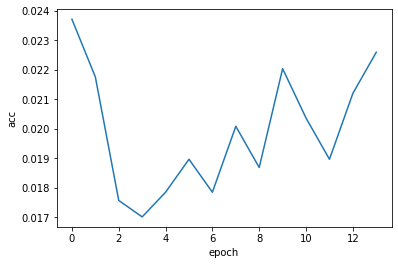

In [83]:
# Nothing mind blowing here.
plt.plot(range(14), acc_vec)
plt.xlabel('epoch')
plt.ylabel('acc')

### 2020-06-18

#### that weird logloss ... 


In [67]:
fu.big_logloss(y_test_enc, y_prob_vec, labels)    

0.0

In [35]:
y_test_enc.shape, y_prob_vec.shape, labels.shape

((3585,), (3585, 54), (54,))

In [36]:
y_test_enc[:5]


array([34, 45, 18, 41,  5])

In [40]:
# Ahh ... so if all the values are super low, logloss fades?
print(np.argmax(y_prob_vec[:5, :], axis=1))
y_prob_vec[:5, :]

[23  7 17  7 20]


array([[3.43320407e-02, 1.45975398e-02, 1.37405249e-03, 3.63272801e-02,
        1.57198533e-02, 1.98668288e-03, 7.11898599e-03, 7.78052211e-02,
        9.97787993e-03, 1.23451920e-02, 2.27672025e-03, 5.64281363e-03,
        8.06225557e-03, 3.40091810e-03, 6.95233792e-03, 1.42584732e-02,
        5.61934011e-03, 9.11897793e-03, 1.73261724e-02, 2.23158412e-02,
        1.78813301e-02, 1.10056736e-01, 3.38553800e-03, 1.13068961e-01,
        1.50842301e-04, 4.20521423e-02, 7.04979850e-03, 1.20025994e-02,
        6.75320439e-03, 7.60487281e-04, 6.79432228e-03, 2.07565799e-02,
        7.43526891e-02, 6.23069294e-02, 4.86901738e-02, 3.42086470e-03,
        2.00877711e-02, 8.52537458e-04, 3.61542945e-04, 1.03140045e-02,
        2.09099017e-02, 2.03171559e-02, 2.66083190e-03, 1.87704358e-02,
        1.21015692e-02, 1.26861909e-03, 5.92931965e-03, 1.36819975e-02,
        9.47918184e-03, 1.92549676e-02, 7.43823545e-03, 2.45635223e-04,
        2.45275471e-04, 3.92340007e-05],
       [1.13724703e-02,

In [65]:
# log_loss(y[:1], y_prob[:1], labels=labels); labe
a, b = np.array([0, 0, 0]), np.array([[0, 0., 0],
                                      [0., 0, 0],
                                      [0., 0, 0]])
print(log_loss(a, b, labels=['a', 'b', 'c']))

a, b = np.array(['a', 'a', 'a']), np.array([[0, 0., 0],
                                      [0., 0, 0],
                                      [0., 0, 0]])
print(log_loss(a, b, labels=['a', 'b', 'c']))

a, b = np.array(['a', 'a', 'a']), np.array([[1, 0., 0],
                                      [1., 0, 0],
                                      [1., 0, 0]])
print(log_loss(a, b, labels=['a', 'b', 'c']))

a, b = np.array(['a', 'a', 'a']), np.array([[0, 1., 0],
                                      [0., 1, 0],
                                      [1., 0, 0]])
print(log_loss(a, b, labels=['a', 'b', 'c']))

# Ok.. so whoops.. log loss was 0.0 because my y_true actually didnt correspond w/ the labels!!!

0.0
1.0986122886681098
2.1094237467877998e-15
23.025850929940457


/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [68]:
fu.big_logloss(y_test_enc, y_prob_vec, labels=list(range(54)))    
# makes sense now.

4.921754919063358

In [52]:
print(y_test_enc.shape, y_prob_vec.shape, labels.shape)


(3585,) (3585, 54) (54,)
